**Import Libraries**

In [16]:
import os
import zipfile
from glob import glob

# Data Manipulation Libraries
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.all import PILImage
from PIL import ImageFilter

# Machine Learning Libraries
import torch
from torchvision import transforms

# **Step 1: Load Data**

In [17]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

In [18]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [19]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}
    
    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [20]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No_Finding,Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,1,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,1,0,/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted/images_001/images/00000003_000.png


# **Step 3: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [21]:
unique_patients = labels_df['Patient ID'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

Number of Unique Patients: 30805


**Distribution of Disease Label**

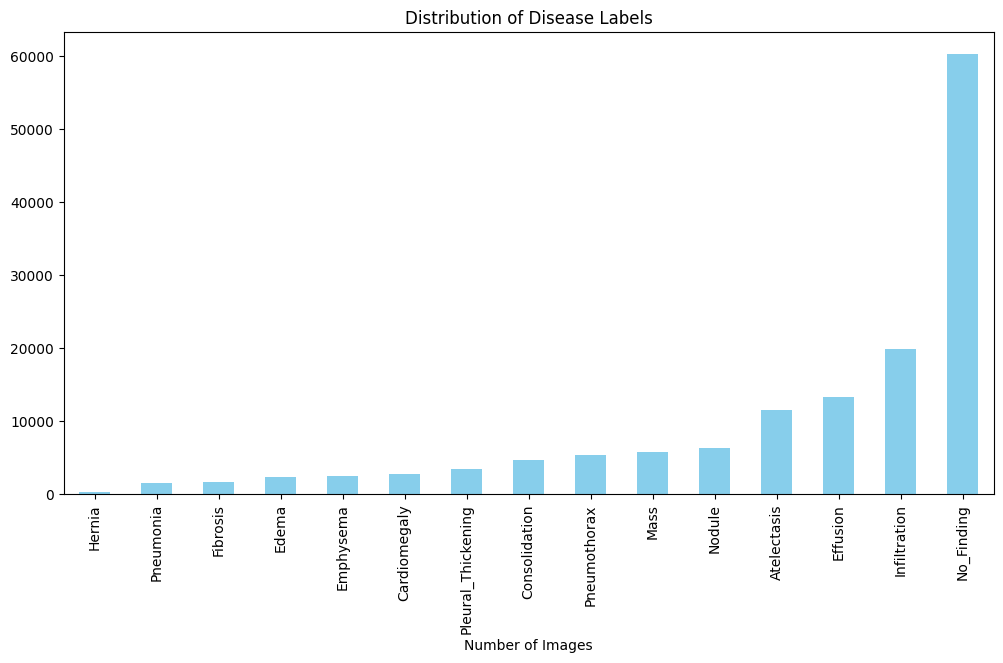

In [22]:
# Retrive the disease labels + "No finding" from dataframe
labels = labels_df[disease_labels + ['No_Finding']]

# Sum each label
counted_labels = labels.sum()

# Sort in descending order
counted_labels = counted_labels.sort_values()

# Plotting from the counted_labels
plt.figure(figsize=(12, 6))
counted_labels.plot(kind='bar', color='skyblue')
plt.xlabel('Number of Images')
plt.title('Distribution of Disease Labels')
plt.show()

**Distribution of Patient Age**

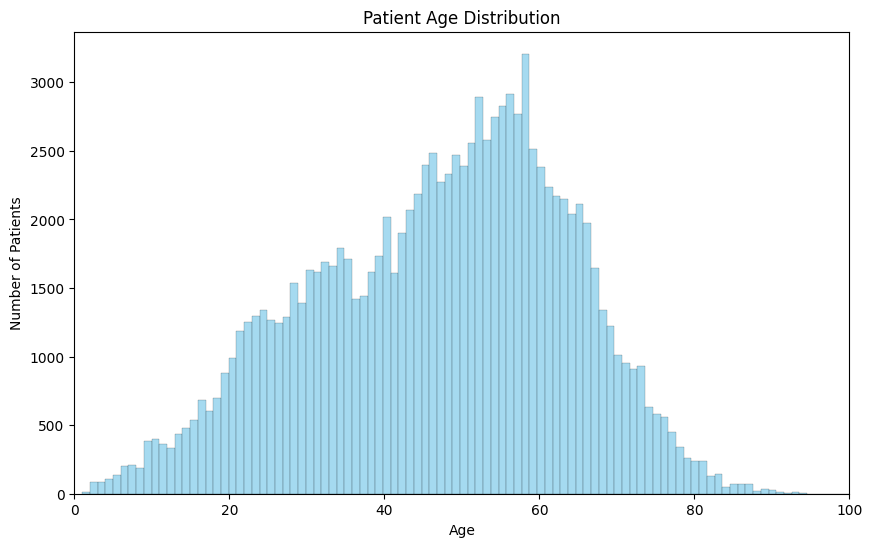

In [23]:
# Patient Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(labels_df['Patient Age'], color='skyblue')
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.xlim(0, 100)
plt.show()

**Distribution of Patient Gender**

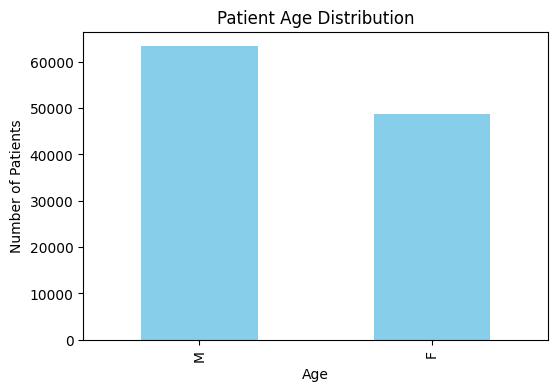

In [24]:
# Count patient age
patient_gender_df = labels_df['Patient Gender'].value_counts()

# Plot patient age distribution
plt.figure(figsize=(6, 4))
patient_gender_df.plot(kind='bar', color='skyblue')
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.show()

**Distribution of View Position**

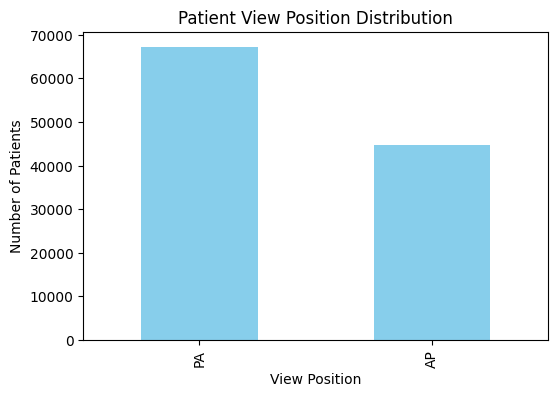

In [25]:
# Count patient gender
patient_view_df = labels_df['View Position'].value_counts()

# Plot patient gender distribution
plt.figure(figsize=(6, 4))
patient_view_df.plot(kind='bar', color='skyblue')
plt.title("Patient View Position Distribution")
plt.xlabel("View Position")
plt.ylabel("Number of Patients")
plt.show()

**Visualize Samples**

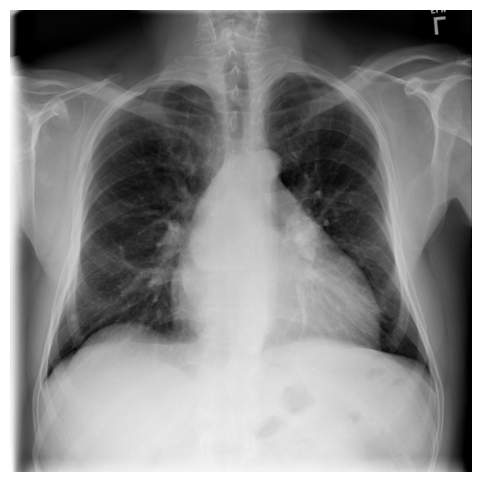

In [26]:
# Choose the path from the first image
img_path = labels_df['Path'].iloc[0]

# Load the image
img = PILImage.create(img_path)

# Display image
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.show()

# **Step 4: Explore Image Preprocessing and Augmentation Techniques**

**Base Transformation**

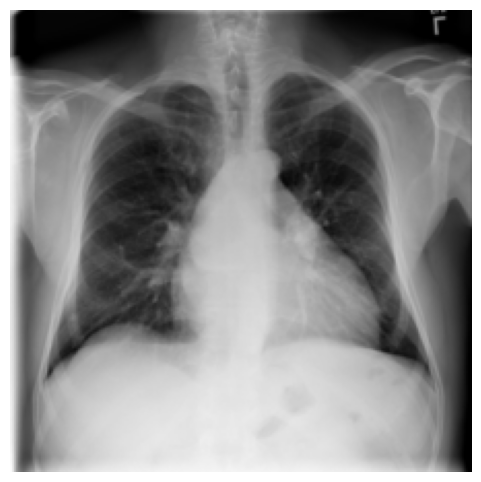

In [27]:
# The base transformation (without augmentation)
base_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
original_img = base_transforms(img)

# Convert to [H, W, C]
original_img = original_img.permute(1, 2, 0).numpy()

# Display image
plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.axis('off')
plt.show()

**Base Transformation + Unsharp Masking**

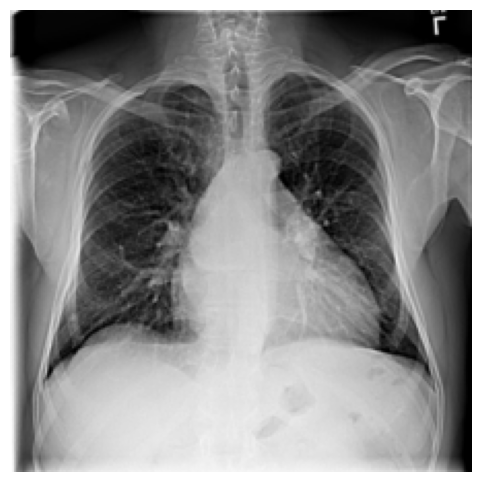

In [28]:
# Apply Unsharp Masking
img = img.filter(ImageFilter.UnsharpMask(radius=5, percent=200, threshold=0))

# The base transformation (without augmentation)
base_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
original_img = base_transforms(img)

# Convert to [H, W, C]
original_img = original_img.permute(1, 2, 0).numpy()

# Display image
plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.axis('off')
plt.show()


**Base Transformation + Rotation**

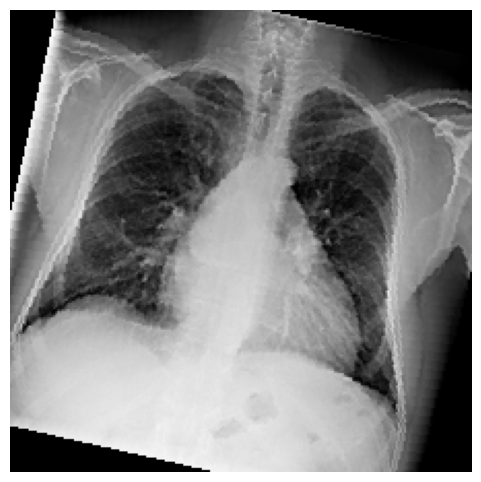

In [42]:
# The base transformation with rotation
base_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    transforms.RandomRotation(20),
])
original_img = base_transforms(img)

# Convert to [H, W, C]
original_img = original_img.permute(1, 2, 0).numpy()

# Display image
plt.figure(figsize=(6,6))
plt.imshow(original_img)
plt.axis('off')
plt.show()